# Composite Score for the Engagement Rate

# Libraries

In [59]:
import pandas as pd
pd.set_option('display.precision', 2)

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import scipy.stats as stats
import pylab

In [60]:
# Module for factor analysis
from factor_analyzer import FactorAnalyzer
# Module for adequacy test
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
# Module for standardization
from sklearn.preprocessing import MinMaxScaler

In [61]:
!pip install pingouin

In [62]:
import pingouin as pg

# Constants

In [63]:
DATA_PATH = '../DATA/news_125k-tokens-relevant.csv'

# Bespoke Functions

In [64]:
# Functions for the logarithmic transformation
def normality(data,feature):
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,1)
    sns.kdeplot(data[feature])
    plt.subplot(1,2,2)
    stats.probplot(data[feature], plot=pylab)
    plt.show()

def run_transformations(data, feature):
    skew_list = []
        
    # raw features (unprocessed)
    normality(data, feature)
    skew_list.append(round(data[str(feature)].skew(), 4))
    
    # logarithmic transformation – This will convert the 'feature' value to its log value i.e log('feature')
    data[str(feature)+'_log'] = np.log(data[feature])
    normality(data, (str(feature)+'_log'))
    skew_list.append(round(data[str(feature)+'_log'].skew(), 4))

    return skew_list    

def highlightLoadings(x):
    '''
    highlight the values if they are greater than 0.5 in a Series yellow.
    '''
    return ['background-color: yellow' if abs(v) > 0.5 else '' for v in x]
def highlightCommunalities(x):
    '''
    highlight the values if they are greater than 0.5 in a Series yellow.
    '''
    return ['background-color: yellow' if v > 0.5 else '' for v in x]
def highlightEigenvalue(x):
    '''
    highlight the values if they are greater than 1 in a Series yellow.
    '''
    return ['background-color: yellow' if v > 1 else '' for v in x]

# Import data

In [65]:
df = pd.read_csv(DATA_PATH, index_col=0)
df.head()

,title,body,category,votes,clicks,comments,text,clean_text,token_lemma,noun_adj_verb,token_lemma_relevant
0,"Muere Toni Batllori, autor de la tira diaria d...",Toni Batllori Obiols ha fallecido esta noche e...,Culture,144,1100,11,"Muere Toni Batllori, autor de la tira diaria d...",Muere Toni Batllori autor de la tira diaria de...,morir Toni Batllori autor tira diario Vanguard...,morir autor tirar diario fallecer noche domici...,morir Toni Batllori autor tirar diario Vanguar...
1,La anarquía explicada a los niños por José A. ...,"En 1931 el maestro José Antonio Emmanuel, y me...",Culture,196,1800,109,La anarquía explicada a los niños por José A. ...,La anarquía explicada a los niños por José A E...,anarquía explicado niño José Emmanuel 1931 mae...,anarquía explicado niño maestro publicar panfl...,anarquía explicado niño José Emmanuel maestro ...
2,"Rhianan Rudd, la adolescente a la que el MI5 a...","Rhianan Rudd, una adolescente de 14 años que v...",Latest,330,6100,77,"Rhianan Rudd, la adolescente a la que el MI5 a...",Rhianan Rudd la adolescente a la que el MI5 ac...,Rhianan Rudd adolescente MI5 acusar terrorismo...,adolescente acusar terrorismo acabar suicidar ...,Rhianan Rudd adolescente MI5 acusar terrorismo...
3,Piden por burofax al obispo de Cartagena que r...,"La catedral de Murcia, la iglesia de El Salvad...",Politics,410,881,54,Piden por burofax al obispo de Cartagena que r...,Piden por burofax al obispo de Cartagena que r...,pedir burofax obispo Cartagena retirar símbolo...,pedir burofax obispo retirar símbolo franquist...,pedir burofax obispo Cartagena retirar símbolo...
4,Érase una vez... (1950),Érase una vez... (1950) dirigida por Josep Esc...,Culture,114,100,9,Érase una vez... (1950) Érase una vez... (1950...,Érase una vez 1950 Érase una vez 1950 dirigida...,érar 1950 era él 1950 dirigido Josep Escobar Z...,érar 1950 1950 dirigido película entero hija c...,érar 1950 ser 1950 dirigido Josep Escobar Zipi...


# Analysis

In [66]:
df.describe()

,votes,clicks,comments
count,123500.00,123500.00,123500.00
mean,499.31,4266.78,93.95
std,381.54,4496.10,82.08
min,10.00,21.00,1.00
25%,246.00,1500.00,40.00
50%,390.00,2900.00,71.00
75%,625.00,5500.00,121.00
max,5600.00,293100.00,1600.00


<Figure size 1000x500 with 0 Axes>

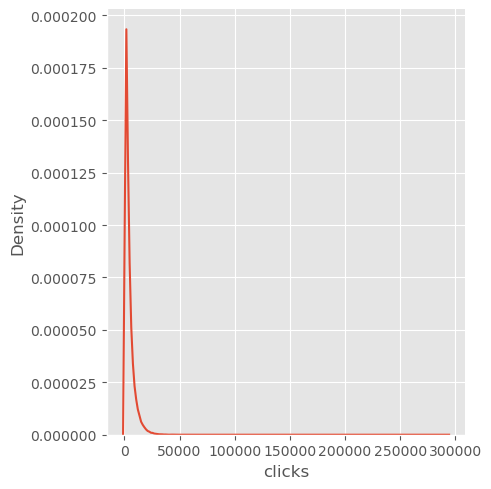

In [67]:
plt.figure(figsize=(10,5))
sns.displot(data=df, x=df['clicks'], kind='kde')
plt.show()

<Figure size 1000x500 with 0 Axes>

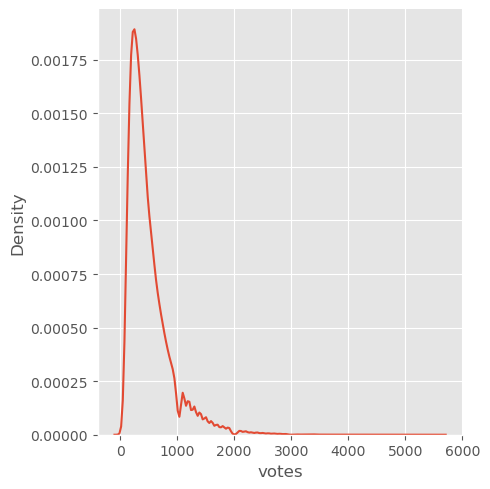

In [68]:
plt.figure(figsize=(10,5))
sns.displot(data=df, x=df['votes'], kind='kde')
plt.show()

<Figure size 1000x500 with 0 Axes>

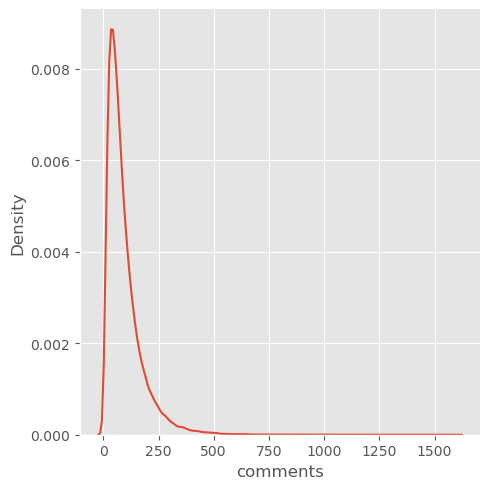

In [69]:
plt.figure(figsize=(10,5))
sns.displot(data=df, x=df['comments'], kind='kde')
plt.show()

# Assumptions

The metrics are ordered according to the degree
a user is willing to publicly associate with the online
content. Hence, a higher engagement level (Level-3)
indicates more public association with the content,
while a lower engagement level (Level-1) means more
private engagement.  
- Level-1 (# views): Private engagement by viewing
social media posts or videos. The number of views
of a given online content is an example of Level-1
engagement, where users only watch the content without
expressing any preferences or giving feedback.
- Level-2 (# likes): Users interact with the content
more publicly in Level-2 by pressing the like or favorite
button. Liked posts, most probably, are shown in
the users’ feeds on the platform where the like action
is taken. That makes the posts more visible to the
users’ friends list (e.g. Facebook and Twitter).
- Level-3 (# comments and # shares): When a user
chooses to share opinions or feelings, that is considered
a more public engagement (Level-3), such as adding a
comment or sharing a post on the same platform
where the content is found. Publicly shared content
is made visible in the user’s timeline with notifications,
if enabled, sent to the user’s network, which makes the
contentmore visible on the same platform. Also, Level-
3 allows private sharing to selected users through private
messaging, where the user may share the content
with only friends who are interested.
  
Another level (4) of engagement would be 'external postings'. It would imply the act of sharing content
from one platform to another is public sharing,
which we consider to have the highest engagement
level in the framework (Level-4). This is because publicly
shared content is exposed to other platforms 
with potentially wider audiences. 
It is not object of this study because we have no data available.



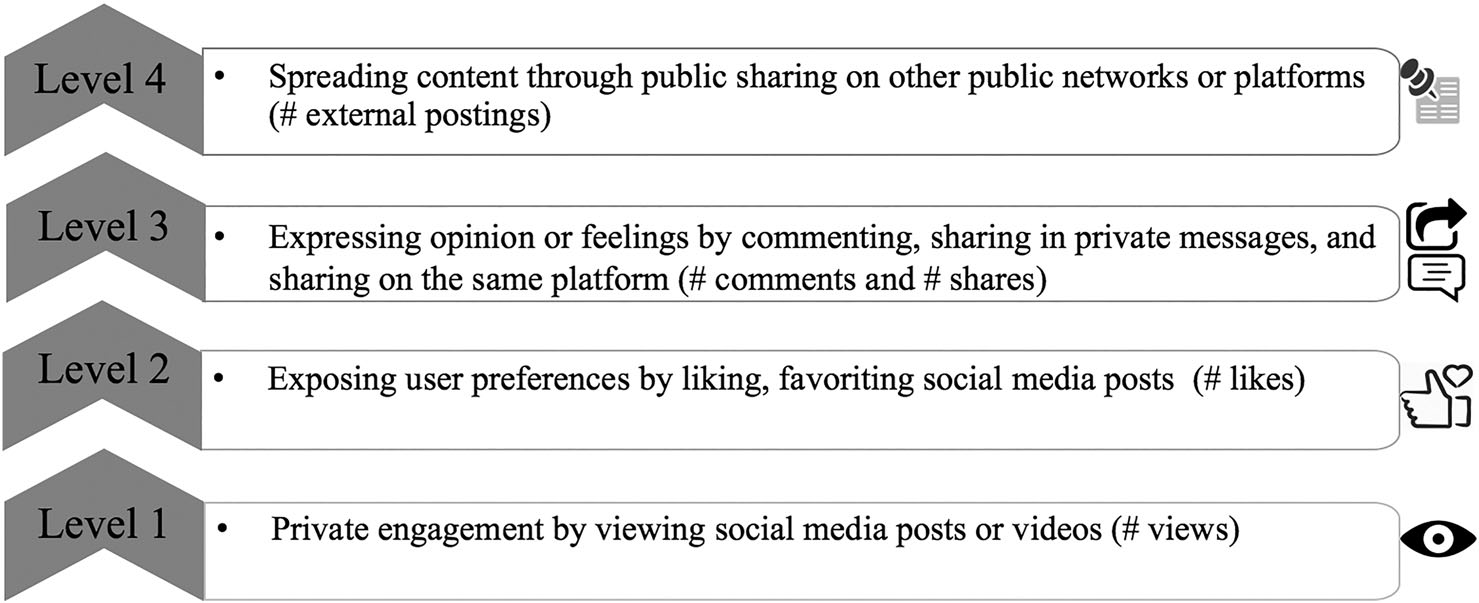

A composite score can be obtained from multiplying each individual scores with their respective factor loading scores and then added up all products together to get a weighted average score.

For each engagement level of the four levels of framework,
we calculate an engagement metric: (a) Level-1
Normalised View (NV), (b) Level-2 Normalised Likes
(NL), (c) Level-3 Normalised Comments (NC), and
(d) Level-4 Normalised External Posting (NEP). The
original values of the engagement metrics in our dataset
are highly skewed; as a result, we use the log normalisation
function to calculate the four normalised engagement
metrics. According to the platforms’ differences
and data limitations, some metrics are measurable
across the five platforms, such as the number of likes
and comments, which helps when finding the crossplatform
differences of Level-2 and Level-3 engagement.
In Reddit, we call the score value of a post, which is a
combination of users’ up and down ratings, as the number
of likes for unifying the metrics naming across platforms.
Also, the number of views is only available on the
YouTube posts of our dataset, while the Level-4 metric
is available on Reddit. For Level-4, we calculate the NEP
through log-normalising the count of the number of
times a news article is posted on a public network (Reddit),
which we call the External Posting Count (EPC). In
this work, we use Reddit public network for measuring
Level-4 engagement; however, other public platforms
can be used, which is subject to data availability.

# Transformations

### Logartimic transformations for skewed data

#### Clicks - visualizations

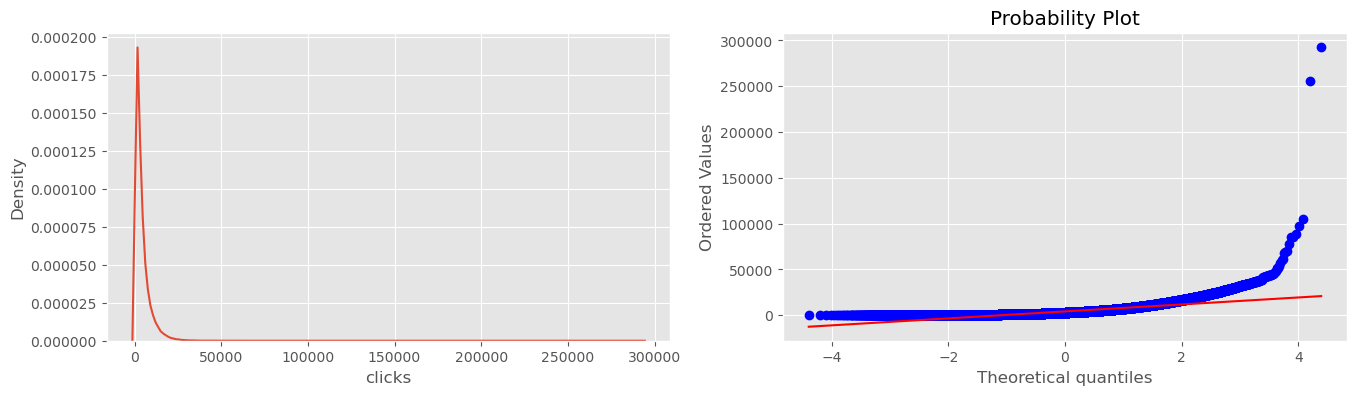

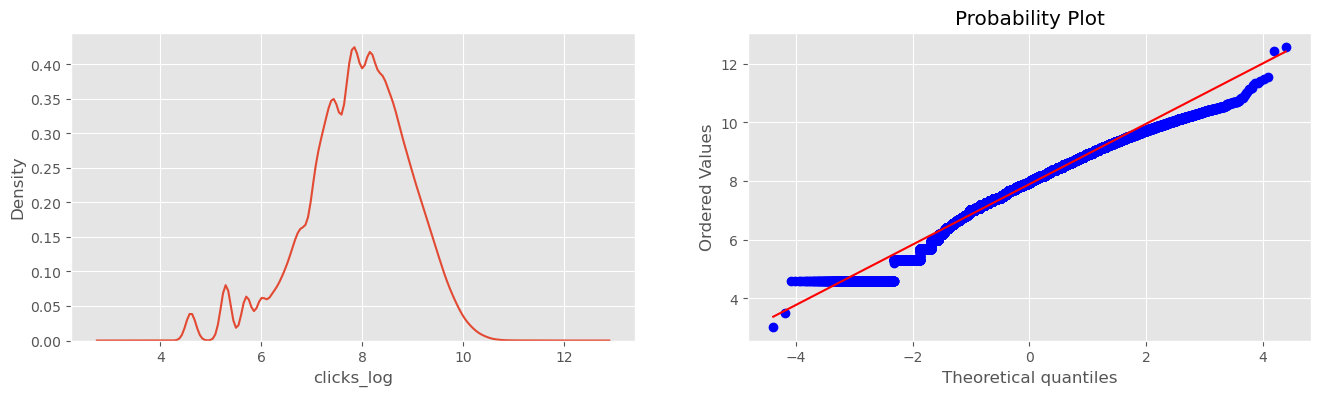

[6.192, -0.5357]

In [70]:
run_transformations(df, 'clicks')

#### Votes - likes

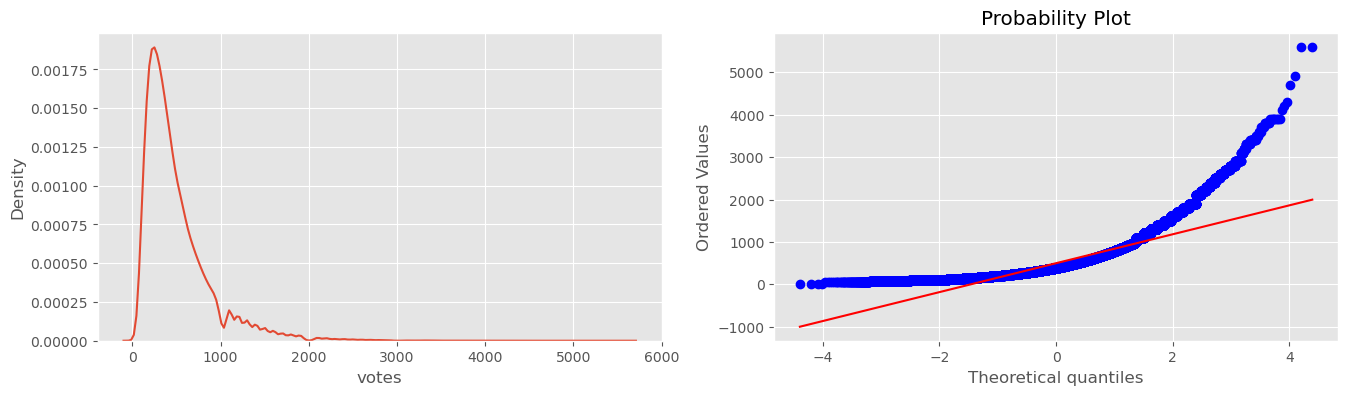

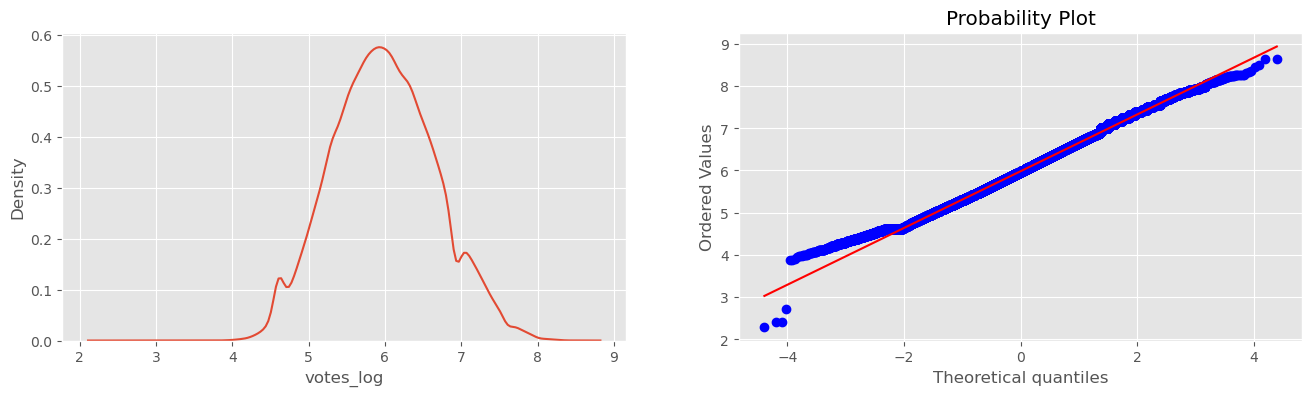

[2.3089, 0.1347]

In [71]:
run_transformations(df, 'votes')

#### Comments

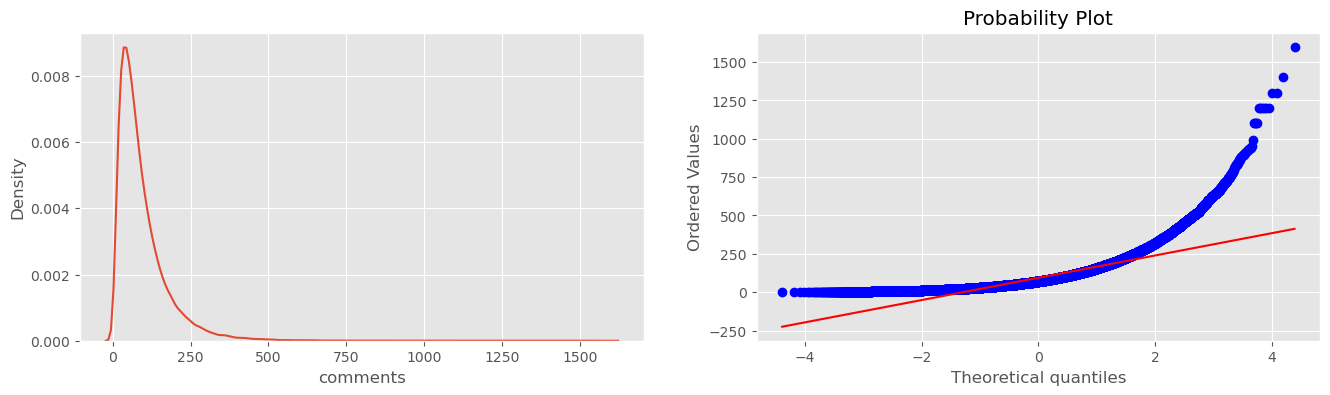

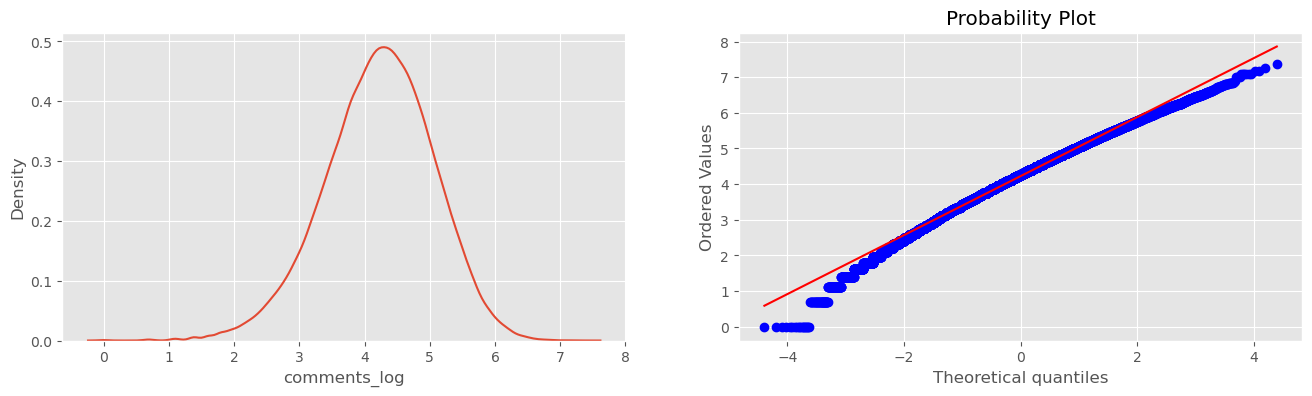

[2.6688, -0.2957]

In [72]:
run_transformations(df, 'comments')

### Normalize data

In [73]:
# Filter the numerical data
df_fix = df[['clicks_log', 'votes_log', 'comments_log']]
# Normalize the factors
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(data = scaler.fit_transform(df_fix),
                         columns = df_fix.columns)
df_scaled.describe()

,clicks_log,votes_log,comments_log
count,123500.00,123500.00,123500.00
mean,0.51,0.58,0.57
std,0.11,0.11,0.11
min,0.00,0.00,0.00
25%,0.45,0.51,0.50
50%,0.52,0.58,0.58
75%,0.58,0.65,0.65
max,1.00,1.00,1.00


# Factor Analysis

In [74]:
# Adequacy test - Bartlett's test
chiSquareValue, pValue = calculate_bartlett_sphericity(df_scaled)
print('Chi-square value : {}'.format(round(chiSquareValue, ndigits = 3)))
print('p-value          : {}'.format(round(pValue, ndigits = 3)))

Chi-square value : 23457.827
p-value          : 0.0


Bartlett test is a test for homogeneity of variances in which the null hypothesis is that all k population variances are equal against the alternative that at least two are different.

The Bartlett test produces a p-value that is less than 0.05. It means, we reject the null hypothesis or in this case, at least two population variances are different.

In [75]:
# Adequacy test - Kaiser-Meyer-Olkin test
KMO, KMO_model = calculate_kmo(df_scaled)
print('KMO value : {}'.format(round(KMO_model, ndigits = 3)))

KMO value : 0.515


In [76]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors = 25, rotation = None)
fa.fit(df_scaled)
# The communalities
df_communalities = pd.DataFrame(data = {'Column': df_scaled.columns, 'Communality': fa.get_communalities()})
df_communalities.style.apply(highlightCommunalities, subset = ['Communality'])

,Column,Communality
0,clicks_log,0.040891
1,votes_log,0.408311
2,comments_log,0.420301


I cannot implement the Factor Analysis, because the communality values do not meet the criteria. Less than 0.5 means that the factors of Factor Analysis is only able to explain less than 50% of the variable's variance. 


# Analytical Hierarchy Process

### Weightened scales

To perform the statistical weight of each scale that is going to be part of the composite score, I have to compare the three options among criteria. On the Analytical Hierarchy Process, it is suggested to run a pair-wise comparison of alternatives (scales) and criteria. And this evaluation is done by assigning intensities that represent various degree of importance. 

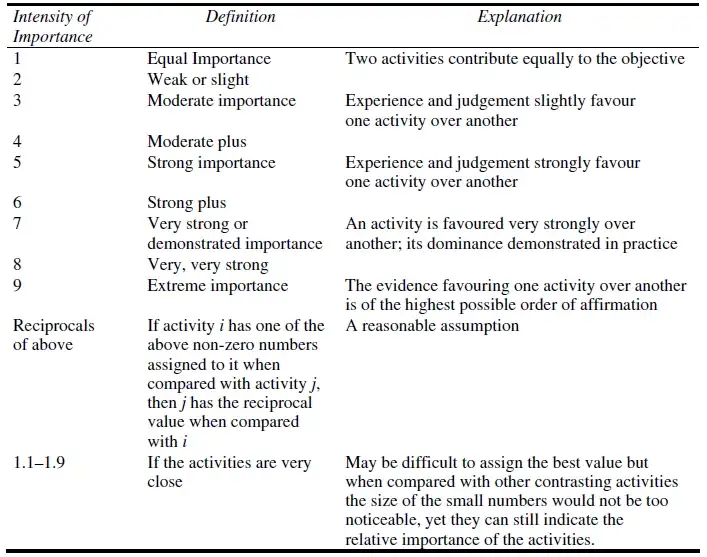

The evaluated/assessed alternatives are compiled into a n x n pair-wise comparison matrix A,for each criteria/sub-criteria/goa


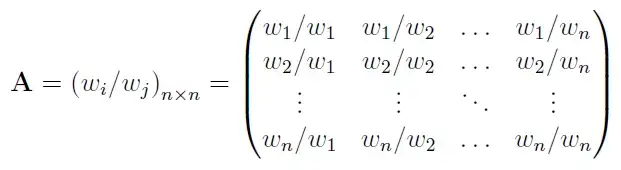

### Creating pair-wise comparison matrix

I am going to use a set of 3 criteria to run the AHP, which are:
- EFFORT: determines the amount of effort needed to make a view, a like or a comment. It can be measured by the amount of time and clicks it needs.
- PRIVACY: determines the amount of privacy exposed, meaning how publicly you expose your opinion.
- VALUE: determines how valuable is the action in relation to serach engines and seo on internet.  
So option 0 is effort, option 1 is privacy and option 2 i value.


In [77]:
n = 3

I am going to create a matrix for the criteria and a matrix for each of the criteria, pairwise evaluating the scales of the composite score. For each matrix generated, I compute the priority vector by normalizing the eigen vector of the largest eigen value. The elements in this eigen vector are the weights of the criteria.

In [78]:
def pairwise_matrix(n):
    # Generate the matrix
    A = np.ones([n,n])
    for i in range(0,n):
        for j in range(0,n):
            if i<j:
                aij = input('How important is option{} over option{} ?: '.format(i,j))
                A[i,j] = float(aij)
                A[j,i] = 1/float(aij)
    # Compute the priority vector 
    eig_val = np.linalg.eig(A)[0].max()
    eig_vec = np.linalg.eig(A)[1][:,0]
    p = eig_vec/eig_vec.sum()
    return p, eig_val

In [79]:
pr_c, e = pairwise_matrix(3)  #All Criteria
pr_c0, e0 = pairwise_matrix(3) #Criteria 0: Effort
pr_c1, e1 = pairwise_matrix(3) #Criteria 1: Privacy
pr_c2, e2 = pairwise_matrix(3) #Criteria 2: Value

How important is option0 over option1 ?: 1
How important is option0 over option2 ?: 0.75
How important is option1 over option2 ?: 0.5
How important is option0 over option1 ?: 1
How important is option0 over option2 ?: 0.25
How important is option1 over option2 ?: 0.5
How important is option0 over option1 ?: 0.75
How important is option0 over option2 ?: 0.5
How important is option1 over option2 ?: 0.75
How important is option0 over option1 ?: 0.75
How important is option0 over option2 ?: 0.5
How important is option1 over option2 ?: 0.75


In [80]:
pr_c # vector for all the criteria

array([0.29412923+0.j, 0.25694555+0.j, 0.44892522+0.j])

In [81]:
pr_c0 # vector of the scales for the criteria 'effort'

array([0.18400201+0.j, 0.23182801+0.j, 0.58416998+0.j])

In [82]:
pr_c1 # vector of the scales for the criteria 'privacy'

array([0.23203353-0.j, 0.32176613-0.j, 0.44620034-0.j])

In [83]:
pr_c2 # vector of the scales for the criteria 'value'

array([0.23203353-0.j, 0.32176613-0.j, 0.44620034-0.j])

The final step is to get their weighted arithmetic sum to yield the rank vector

In [84]:
r = pr_c0*pr_c[0] + pr_c1*pr_c[1] + pr_c2*pr_c[2]
print(r)

[0.21790606+0.j 0.2953127 +0.j 0.48678125+0.j]


#### Consistency Ratio

In [85]:
e0, e1, e2 # normalized eigen values

((3.053621575878975+0j), (3.001541625064223+0j), (3.001541625064223+0j))

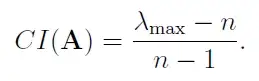

Where lambda_max is the maximum eigen value of the pair-wise comparison matrix and n is the number of alternatives.

In [86]:
consistency_index = (e0 - n)/n - 1
consistency_index

(-0.982126141373675+0j)

To scale for different size matrices, the Consistency Ratio was developed, CR

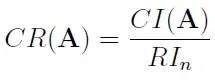

Where, RI_n is an average estimate of the CI obtained from a large enough set of randomly generated matrices of size n.

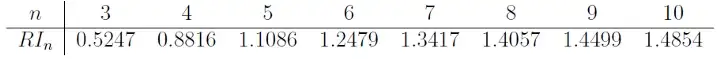

In [87]:
rn_i = 0.5247

In [88]:
consistency_ratio = consistency_index / rn_i
consistency_ratio

(-1.8717860517889744+0j)

We can accept the consistency ratio, because CR ≤ 0.1. A value of CR = 0.1 basically means that the judgments are 10% as inconsistent as if they had been given randomly. In theses cases, one could try to reduce this inconsistency, and the only way to do that is to go back and re-evaluate the subjective weights.

### Set up the weights from the vector

In [89]:
w1 = 0.2125
w2 = 0.2932
w3 = 0.4943
w1 + w2 + w3

1.0

### Generate the score

In [90]:
df['score'] = df['clicks_log']*w1 + df['votes_log']*w2 + df['comments_log']*w3

In [91]:
df.head()

,title,body,category,votes,clicks,comments,text,clean_text,token_lemma,noun_adj_verb,token_lemma_relevant,clicks_log,votes_log,comments_log,score
0,"Muere Toni Batllori, autor de la tira diaria d...",Toni Batllori Obiols ha fallecido esta noche e...,Culture,144,1100,11,"Muere Toni Batllori, autor de la tira diaria d...",Muere Toni Batllori autor de la tira diaria de...,morir Toni Batllori autor tira diario Vanguard...,morir autor tirar diario fallecer noche domici...,morir Toni Batllori autor tirar diario Vanguar...,7.00,4.97,2.40,4.13
1,La anarquía explicada a los niños por José A. ...,"En 1931 el maestro José Antonio Emmanuel, y me...",Culture,196,1800,109,La anarquía explicada a los niños por José A. ...,La anarquía explicada a los niños por José A E...,anarquía explicado niño José Emmanuel 1931 mae...,anarquía explicado niño maestro publicar panfl...,anarquía explicado niño José Emmanuel maestro ...,7.50,5.28,4.69,5.46
2,"Rhianan Rudd, la adolescente a la que el MI5 a...","Rhianan Rudd, una adolescente de 14 años que v...",Latest,330,6100,77,"Rhianan Rudd, la adolescente a la que el MI5 a...",Rhianan Rudd la adolescente a la que el MI5 ac...,Rhianan Rudd adolescente MI5 acusar terrorismo...,adolescente acusar terrorismo acabar suicidar ...,Rhianan Rudd adolescente MI5 acusar terrorismo...,8.72,5.80,4.34,5.70
3,Piden por burofax al obispo de Cartagena que r...,"La catedral de Murcia, la iglesia de El Salvad...",Politics,410,881,54,Piden por burofax al obispo de Cartagena que r...,Piden por burofax al obispo de Cartagena que r...,pedir burofax obispo Cartagena retirar símbolo...,pedir burofax obispo retirar símbolo franquist...,pedir burofax obispo Cartagena retirar símbolo...,6.78,6.02,3.99,5.18
4,Érase una vez... (1950),Érase una vez... (1950) dirigida por Josep Esc...,Culture,114,100,9,Érase una vez... (1950) Érase una vez... (1950...,Érase una vez 1950 Érase una vez 1950 dirigida...,érar 1950 era él 1950 dirigido Josep Escobar Z...,érar 1950 1950 dirigido película entero hija c...,érar 1950 ser 1950 dirigido Josep Escobar Zipi...,4.61,4.74,2.20,3.45


### Generate a rank

In [92]:
df['rank'] = df['score'].rank(ascending = False)
df.sort_values(by = 'rank').head(5)

,title,body,category,votes,clicks,comments,text,clean_text,token_lemma,noun_adj_verb,token_lemma_relevant,clicks_log,votes_log,comments_log,score,rank
110365,"El CIS anuncia un terremoto: Podemos, primera ...",Según ha podido saber CRÓNICA GLOBAL de fuente...,Politics,5600,32500,660,"El CIS anuncia un terremoto: Podemos, primera ...",El CIS anuncia un terremoto Podemos primera fu...,CIS anunciar terremoto fuerza intención direct...,anunciar terremoto fuerza intención directo vo...,CIS anunciar terremoto fuerza intención direct...,10.39,8.63,6.49,7.95,1.0
95103,"""Nos van a dar pero bien""(reacción de los pres...",Grabado en periscope la reacción de los presen...,Latest,2900,40800,835,"""Nos van a dar pero bien""(reacción de los pres...",Nos van a dar pero bienreacción de los present...,bienreacción presentador exclusiva antena 3 Gr...,presentador exclusivo antena reacción presenta...,bienreacción presentador exclusivo antena Grab...,10.62,7.97,6.73,7.92,2.0
26752,Pablo Iglesias dimite de todos sus cargos y de...,Pablo Iglesias dimite de todos sus cargos y de...,Latest,2200,9400,1600,Pablo Iglesias dimite de todos sus cargos y de...,Pablo Iglesias dimite de todos sus cargos y de...,Pablo Iglesias dimitir cargo dejar política Pa...,dimitir cargo dejar política dimitir cargo dej...,Pablo Iglesias dimitir cargo dejar política Pa...,9.15,7.70,7.38,7.85,3.0
116342,Muere a tiros Isabel Carrasco en la pasarela d...,La presidenta de la Diputación y del PP de Leó...,Latest,2800,18600,943,Muere a tiros Isabel Carrasco en la pasarela d...,Muere a tiros Isabel Carrasco en la pasarela d...,morir tiro Isabel Carrasco pasarela río unir c...,morir tiro unir casa sede presidenta morir esc...,morir tiro Isabel Carrasco pasarela río unir c...,9.83,7.94,6.85,7.80,4.0
29026,Pablo Iglesias deja el Gobierno para disputar ...,Pablo Iglesias disputará a Isabel Díaz Ayuso l...,Latest,2500,11100,1200,Pablo Iglesias deja el Gobierno para disputar ...,Pablo Iglesias deja el Gobierno para disputar ...,Pablo Iglesias dejar Gobierno disputar preside...,dejar disputar presidencia disputar presidencia,Pablo Iglesias dejar Gobierno disputar preside...,9.31,7.82,7.09,7.78,5.0


### Generate the above/Below the average

In [93]:
stat = ['Above' if i > df['score'].mean() else 'Below' for i in df['score']]
df['status'] = stat
df.head(5)

,title,body,category,votes,clicks,comments,text,clean_text,token_lemma,noun_adj_verb,token_lemma_relevant,clicks_log,votes_log,comments_log,score,rank,status
0,"Muere Toni Batllori, autor de la tira diaria d...",Toni Batllori Obiols ha fallecido esta noche e...,Culture,144,1100,11,"Muere Toni Batllori, autor de la tira diaria d...",Muere Toni Batllori autor de la tira diaria de...,morir Toni Batllori autor tira diario Vanguard...,morir autor tirar diario fallecer noche domici...,morir Toni Batllori autor tirar diario Vanguar...,7.00,4.97,2.40,4.13,121598.0,Below
1,La anarquía explicada a los niños por José A. ...,"En 1931 el maestro José Antonio Emmanuel, y me...",Culture,196,1800,109,La anarquía explicada a los niños por José A. ...,La anarquía explicada a los niños por José A E...,anarquía explicado niño José Emmanuel 1931 mae...,anarquía explicado niño maestro publicar panfl...,anarquía explicado niño José Emmanuel maestro ...,7.50,5.28,4.69,5.46,69581.0,Below
2,"Rhianan Rudd, la adolescente a la que el MI5 a...","Rhianan Rudd, una adolescente de 14 años que v...",Latest,330,6100,77,"Rhianan Rudd, la adolescente a la que el MI5 a...",Rhianan Rudd la adolescente a la que el MI5 ac...,Rhianan Rudd adolescente MI5 acusar terrorismo...,adolescente acusar terrorismo acabar suicidar ...,Rhianan Rudd adolescente MI5 acusar terrorismo...,8.72,5.80,4.34,5.70,48443.0,Above
3,Piden por burofax al obispo de Cartagena que r...,"La catedral de Murcia, la iglesia de El Salvad...",Politics,410,881,54,Piden por burofax al obispo de Cartagena que r...,Piden por burofax al obispo de Cartagena que r...,pedir burofax obispo Cartagena retirar símbolo...,pedir burofax obispo retirar símbolo franquist...,pedir burofax obispo Cartagena retirar símbolo...,6.78,6.02,3.99,5.18,91042.0,Below
4,Érase una vez... (1950),Érase una vez... (1950) dirigida por Josep Esc...,Culture,114,100,9,Érase una vez... (1950) Érase una vez... (1950...,Érase una vez 1950 Érase una vez 1950 dirigida...,érar 1950 era él 1950 dirigido Josep Escobar Z...,érar 1950 1950 dirigido película entero hija c...,érar 1950 ser 1950 dirigido Josep Escobar Zipi...,4.61,4.74,2.20,3.45,123376.0,Below


### Generate labels

In [108]:
df['score_name'] = pd.qcut(df['score'], 3, labels=['C', 'B', 'A'])
df.head(5)

,title,body,category,votes,clicks,comments,text,clean_text,token_lemma,noun_adj_verb,token_lemma_relevant,clicks_log,votes_log,comments_log,score,rank,status,score_name
0,"Muere Toni Batllori, autor de la tira diaria d...",Toni Batllori Obiols ha fallecido esta noche e...,Culture,144,1100,11,"Muere Toni Batllori, autor de la tira diaria d...",Muere Toni Batllori autor de la tira diaria de...,morir Toni Batllori autor tira diario Vanguard...,morir autor tirar diario fallecer noche domici...,morir Toni Batllori autor tirar diario Vanguar...,7.00,4.97,2.40,4.13,121598.0,Below,C
1,La anarquía explicada a los niños por José A. ...,"En 1931 el maestro José Antonio Emmanuel, y me...",Culture,196,1800,109,La anarquía explicada a los niños por José A. ...,La anarquía explicada a los niños por José A E...,anarquía explicado niño José Emmanuel 1931 mae...,anarquía explicado niño maestro publicar panfl...,anarquía explicado niño José Emmanuel maestro ...,7.50,5.28,4.69,5.46,69581.0,Below,B
2,"Rhianan Rudd, la adolescente a la que el MI5 a...","Rhianan Rudd, una adolescente de 14 años que v...",Latest,330,6100,77,"Rhianan Rudd, la adolescente a la que el MI5 a...",Rhianan Rudd la adolescente a la que el MI5 ac...,Rhianan Rudd adolescente MI5 acusar terrorismo...,adolescente acusar terrorismo acabar suicidar ...,Rhianan Rudd adolescente MI5 acusar terrorismo...,8.72,5.80,4.34,5.70,48443.0,Above,B
3,Piden por burofax al obispo de Cartagena que r...,"La catedral de Murcia, la iglesia de El Salvad...",Politics,410,881,54,Piden por burofax al obispo de Cartagena que r...,Piden por burofax al obispo de Cartagena que r...,pedir burofax obispo Cartagena retirar símbolo...,pedir burofax obispo retirar símbolo franquist...,pedir burofax obispo Cartagena retirar símbolo...,6.78,6.02,3.99,5.18,91042.0,Below,C
4,Érase una vez... (1950),Érase una vez... (1950) dirigida por Josep Esc...,Culture,114,100,9,Érase una vez... (1950) Érase una vez... (1950...,Érase una vez 1950 Érase una vez 1950 dirigida...,érar 1950 era él 1950 dirigido Josep Escobar Z...,érar 1950 1950 dirigido película entero hija c...,érar 1950 ser 1950 dirigido Josep Escobar Zipi...,4.61,4.74,2.20,3.45,123376.0,Below,C


# Mesure of reliability

### Cronbach's alpha

Cronbach's alpha measures internal consistency. Internal consistency describes the extent to which all the items in a test measure the same concept or construct and hence it is connected to the inter-relatedness of the items within the test. 

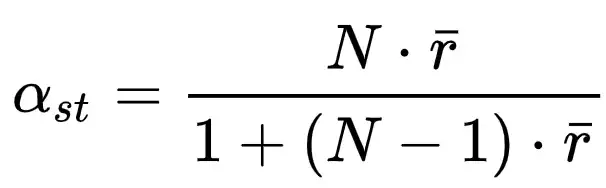

Here, N is the number of items (questions) and r is the mean correlation between the items.

In [95]:
def cronbach_alpha(df):
    # 1. Transform the df into a correlation matrix
    df_corr = df.corr()
    
    # 2.1 Calculate N
    # The number of variables equals the number of columns in the df
    N = df.shape[1]
    
    # 2.2 Calculate R
    # For this, we'll loop through the columns and append every
    # relevant correlation to an array calles "r_s". Then, we'll
    # calculate the mean of "r_s"
    rs = np.array([])
    for i, col in enumerate(df_corr.columns):
        sum_ = df_corr[col][i+1:].values
        rs = np.append(sum_, rs)
    mean_r = np.mean(rs)
    
   # 3. Use the formula to calculate Cronbach's Alpha 
    cronbach_alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
    return cronbach_alpha

In [96]:
cronbach_alpha(df_scaled[['clicks_log', 'votes_log', 'comments_log']])

0.41359360361999187

#### Checking with the library pingouin

In [97]:
pg.cronbach_alpha(data=df_scaled[['clicks_log', 'votes_log', 'comments_log']])

(0.414292821336102, array([0.409, 0.42 ]))

Cronbach’s Alpha turns out to be 0.41

The 95% confidence interval for Cronbach’s Alpha is also given: [0.409, 0.420 ].

#### By pairs

In [98]:
pg.cronbach_alpha(data=df_scaled[['clicks_log', 'votes_log']])

(0.13409519025346772, array([0.124, 0.144]))

In [99]:
pg.cronbach_alpha(data=df_scaled[['clicks_log', 'comments_log']])

(0.17098158666225882, array([0.162, 0.18 ]))

In [100]:
pg.cronbach_alpha(data=df_scaled[['votes_log', 'comments_log']])

(0.5765141061568038, array([0.572, 0.581]))

#### With the score

In [101]:
pg.cronbach_alpha(data=df[['clicks_log', 'votes_log', 'comments_log', 'score']])

(0.6765260698867674, array([0.674, 0.679]))

In [102]:
pg.cronbach_alpha(data=df[['clicks_log', 'score']])

(0.5700875433552719, array([0.565, 0.575]))

In [103]:
pg.cronbach_alpha(data=df[['votes_log', 'score']])

(0.7809128942718648, array([0.778, 0.783]))

In [104]:
pg.cronbach_alpha(data=df[['comments_log', 'score']])

(0.9014201759339207, array([0.9  , 0.903]))

### Conclusions

A low value of alpha could be due to a low number of questions, poor inter-relatedness between items or heterogeneous constructs. 


Although it might seem wierd, the three scales that conform the composite score are low correlated. However, the internal consistency of the score with each of the scale is pretty high and the values are consistent with the operations done to the formulation of the composite score. The highest the weight of the scale, the more correlated are the score and the scale itself, performing exactly the way we expected it to perform.

# Save File

In [109]:
df.to_csv('../DATA/news_125k-with_score.csv')

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123500 entries, 0 to 123499
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   title                 123500 non-null  object  
 1   body                  123500 non-null  object  
 2   category              123500 non-null  object  
 3   votes                 123500 non-null  int64   
 4   clicks                123500 non-null  int64   
 5   comments              123500 non-null  int64   
 6   text                  123500 non-null  object  
 7   clean_text            123500 non-null  object  
 8   token_lemma           123500 non-null  object  
 9   noun_adj_verb         123414 non-null  object  
 10  token_lemma_relevant  123500 non-null  object  
 11  clicks_log            123500 non-null  float64 
 12  votes_log             123500 non-null  float64 
 13  comments_log          123500 non-null  float64 
 14  score                 123500 non-nul